This notebook consists of an exploratory data analysis for the normal data available in the 3W Dataset. For more details about the dataset, check [VARGAS et al. (2019)](https://linkinghub.elsevier.com/retrieve/pii/S0920410519306357). For more in-depth exploratory analysis of the 3W Dataset and others process systems engineering datasets, check [MELO et al. (2022)](https://www.sciencedirect.com/science/article/abs/pii/S0098135422003003).

##Installing dependences

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install missingno
!pip install pyarrow

##Importing dependences

In [ ]:
import os
import copy
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import missingno

import pyarrow




## Reference table of variables

In [ ]:
tags = {'P-PDG':'Pa',
        'P-TPT':'Pa', 'T-TPT':'degC',
         'P-MON-CKP':'Pa', 'T-JUS-CKP':'degC',
         'P-JUS-CKGL':'Pa', 'T-JUS-CKGL':'degC',
         'QGL': 'sm^3/s'}

names = ['Pressure at the PDG',
         'Pressure at the TPT',
         'Temperature at the TPT',
         'Pressure upstream of the PCK',
         'Temperature downstream of the PCK',
         'Pressure downstream of the GLCK',
         'Temperature downstream of the GLCK',
         'Gas lift flow rate']

reference_table = pd.DataFrame(index=np.arange(1,len(names)+1))
reference_table.index.name='Number'
reference_table['Tag'] = tags.keys()
reference_table['Name'] = names
reference_table['Unit'] = tags.values()
reference_table

,Tag,Name,Unit
Number,,,
1,P-PDG,Pressure at the PDG,Pa
2,P-TPT,Pressure at the TPT,Pa
3,T-TPT,Temperature at the TPT,degC
4,P-MON-CKP,Pressure upstream of the PCK,Pa
5,T-JUS-CKP,Temperature downstream of the PCK,degC
6,P-JUS-CKGL,Pressure downstream of the GLCK,Pa
7,T-JUS-CKGL,Temperature downstream of the GLCK,degC
8,QGL,Gas lift flow rate,sm^3/s


In [ ]:
plt.rc('font', family='serif', size=12) # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

## Data importing

In [ ]:

EVENT = 0
PATH = os.path.join('..', '..', 'dataset', str(EVENT))
dfs = {}
if os.path.exists(PATH):
    files = [f for f in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, f)) and f.endswith('.parquet')]

    for file in files:

        well_number = file.split('_')[0]
        well_id = well_number.split('-')[1]
        dfs[well_id] = pd.read_parquet(os.path.join(PATH, file)).rename_axis(None)

    print('Dados lidos!\nNúmero de instâncias: ', len(dfs))
else:
    print(f"Caminho {PATH} não existe.")


Dados lidos!
Número de instâncias:  9


## Visualization functions

The following functions help us to obtain time series and scatter plots for this dataset.

In [ ]:
def plot_tag(tag, sampling=60):
    hsv = plt.get_cmap('Paired')
    colors = hsv(np.linspace(0, 1, len(dfs)))

    fig, ax = plt.subplots(figsize=(15, 10))

    for idx, (well_id, df) in enumerate(dfs.items()):
        if tag in df.columns:
            ax.plot(df[tag][::sampling].values, color=colors[idx], label=f'Well {int(well_id)}', ls='', marker='.')
            ax.axhline(df[tag][::sampling].values.mean(), color=colors[idx], ls='--', marker='')

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    desired_order_list = sorted(by_label.keys(), key=lambda x: int(x.split()[1]))
    reordered_dict = {k: by_label[k] for k in desired_order_list}
    ax.legend(reordered_dict.values(), reordered_dict.keys(), prop={'size': 12}, markerscale=5)
    ax.set_ylabel(tags.get(tag, 'Unidade'))
    ax.set_title(tag)
    plt.show()


In [ ]:
def scatterplot(data, columns, ax, spines=False, px=5, n=None):
    if n is None:
        n = data.shape[1]
    for i in range(n):
        for j in range(n):
            if i <= j:
                ax[i, j].set_visible(False)
            else:
                sns.kdeplot(x=data.iloc[:, j], y=data.iloc[:, i], ax=ax[i, j], cmap="Blues", shade=True, bw_adjust=.5)
                if j == 0:
                    ax[i, j].set_ylabel(columns[i])
                if i == n - 1:
                    ax[i, j].set_xlabel(columns[j])
            ax[i, j].xaxis.set_ticks([])
            ax[i, j].yaxis.set_ticks([])
            if not spines:
                ax[i, j].spines['top'].set_visible(False)
                ax[i, j].spines['right'].set_visible(False)
                ax[i, j].spines['bottom'].set_visible(False)
                ax[i, j].spines['left'].set_visible(False)

In [ ]:

def plot_timeseries_well(ax, data):
    n_vars = data.shape[1]
    for i in range(n_vars):
        ax[i].plot(data.iloc[:, i].values, c='k', linewidth=0.8)
        ax[i].set_ylabel(data.columns[i], rotation=0, fontsize=14)
        ax[i].set_yticks([])
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["left"].set_visible(False)
        if i < (n_vars - 1):
            ax[i].set_xticks([])
            ax[i].spines["bottom"].set_visible(False)
            ax[i].xaxis.set_ticks_position('none')
        else:
            for label in ax[i].get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')
    return data



In [ ]:
def plot_periods(data, yticks=False):
    n_vars = data.shape[1]

    fig = plt.figure(constrained_layout=True, figsize=(16, 6))
    subfigs = fig.subfigures(1, 2, wspace=0.03)
    ax1 = subfigs[0].subplots(n_vars, 1, sharex=True)

    df_plot = data.drop_duplicates()

    for i in range(n_vars):
        ax1[i].plot(df_plot.index, df_plot.iloc[:, i], color='k', linewidth=0.8)
        ax1[i].set_ylabel(data.columns[i], rotation=0, fontsize=14)
        if not yticks:
            ax1[i].set_yticks([])
        ax1[i].spines["top"].set_visible(False)
        ax1[i].spines["right"].set_visible(False)
        ax1[i].spines["left"].set_visible(False)
        if i < (n_vars - 1):
            ax1[i].set_xticks([])
            ax1[i].spines["bottom"].set_visible(False)
            ax1[i].xaxis.set_ticks_position('none')
        else:
            for label in ax1[i].get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')

    ax2 = subfigs[1].subplots(n_vars, n_vars)

    scatterplot(data=df_plot.iloc[:, :n_vars], columns=data.columns, ax=ax2, spines=False)

    plt.show()
    return df_plot

In [ ]:
table_periods = pd.DataFrame(columns=['Start','End','Variables','No. of instances'])
table_periods.index.name = 'ID'

## Visualization

### Time series plots

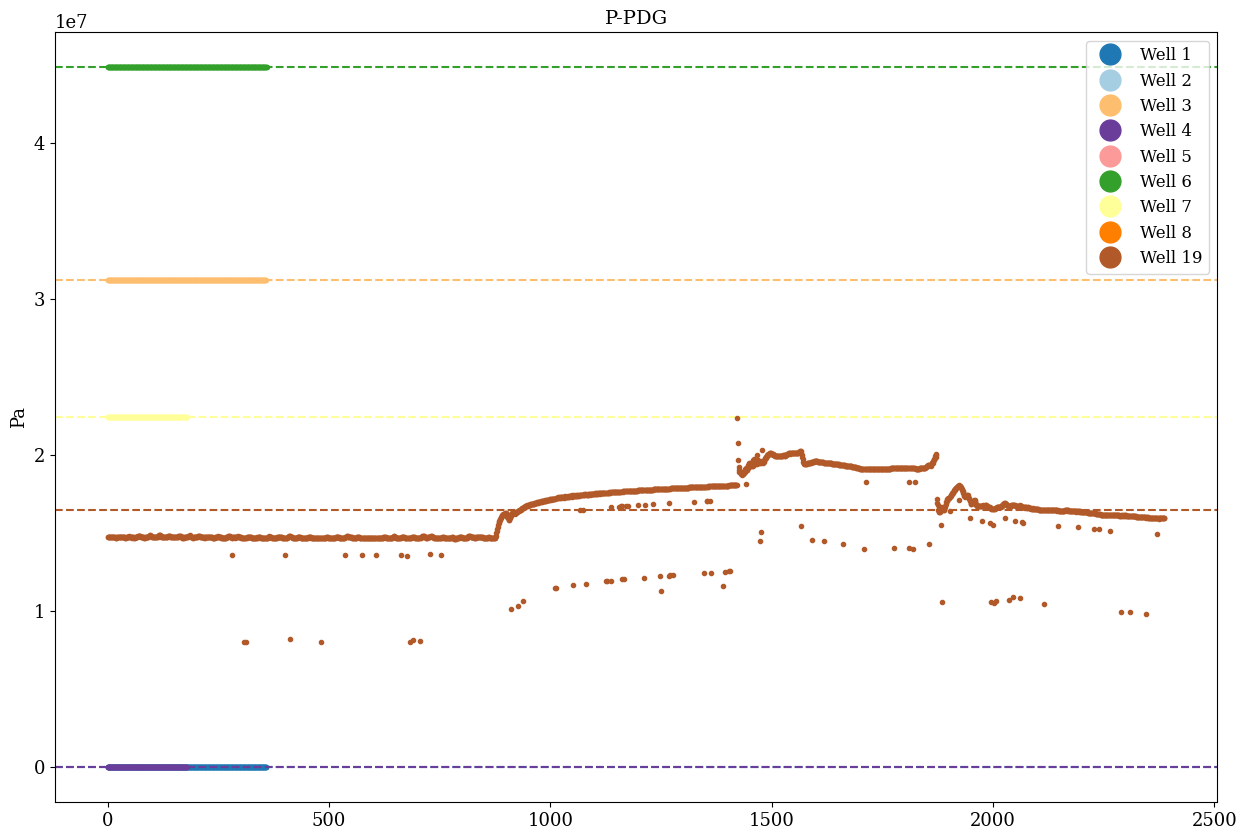

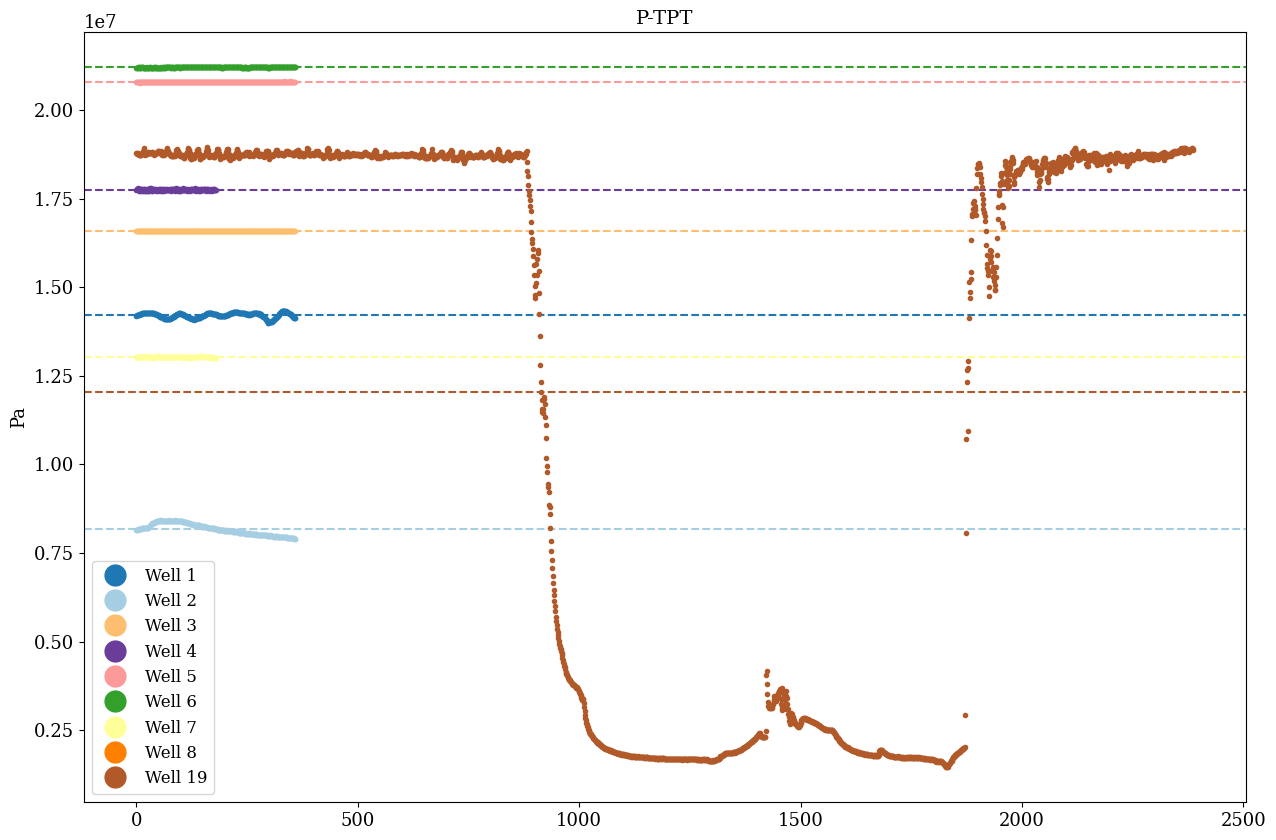

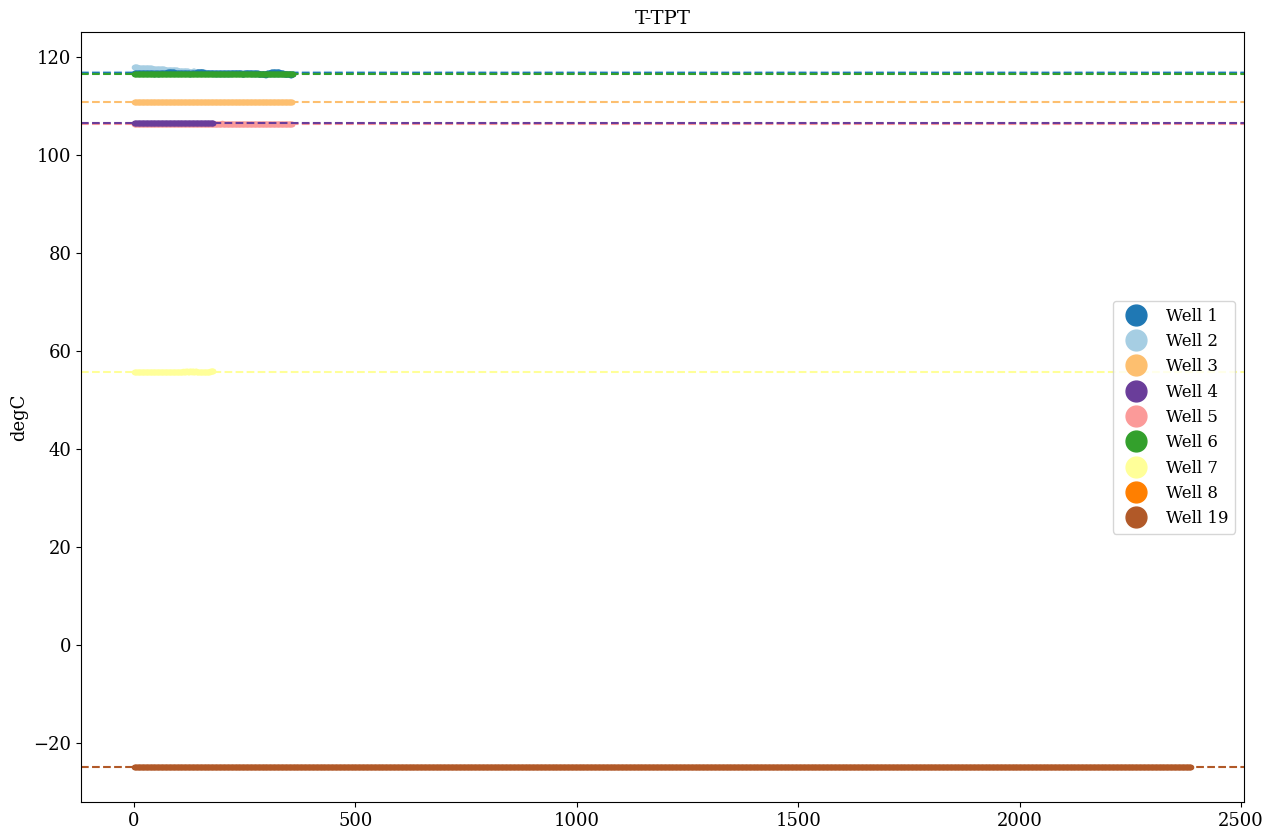

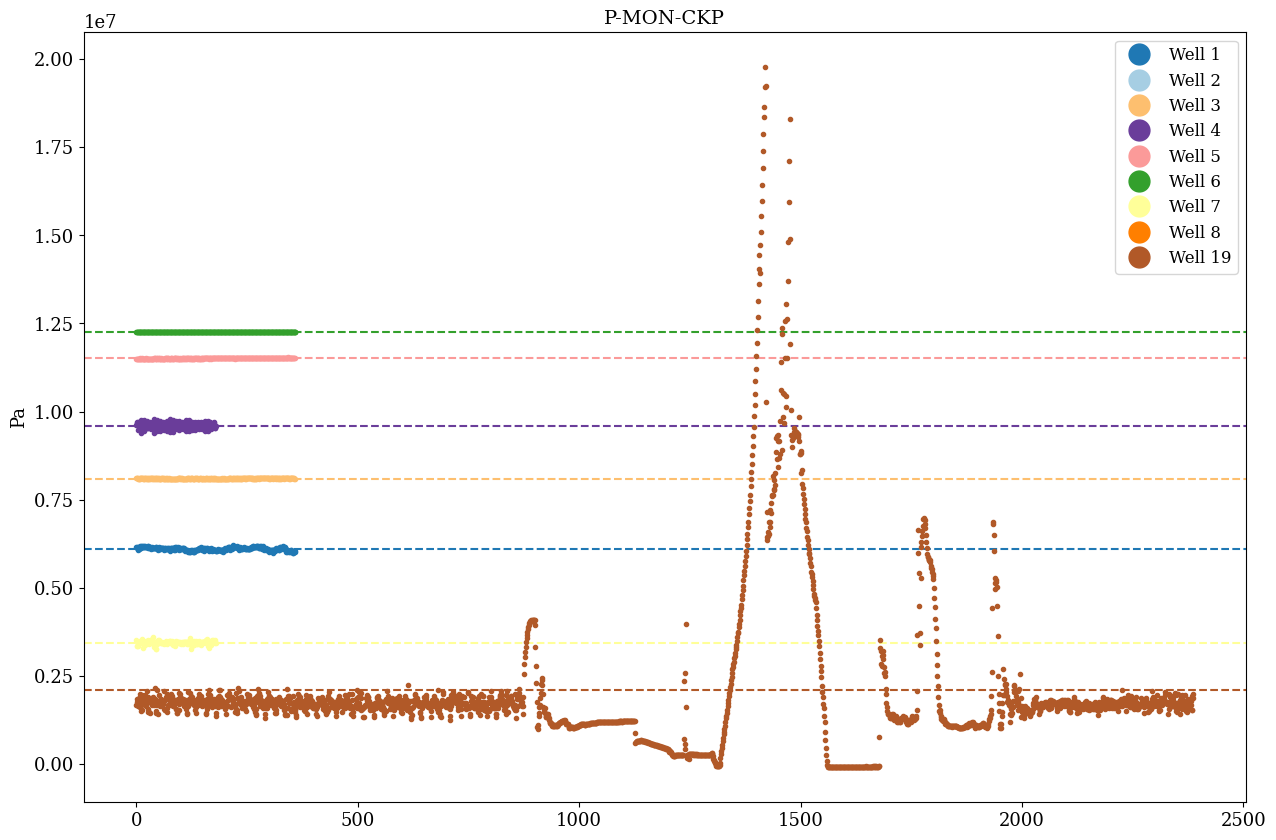

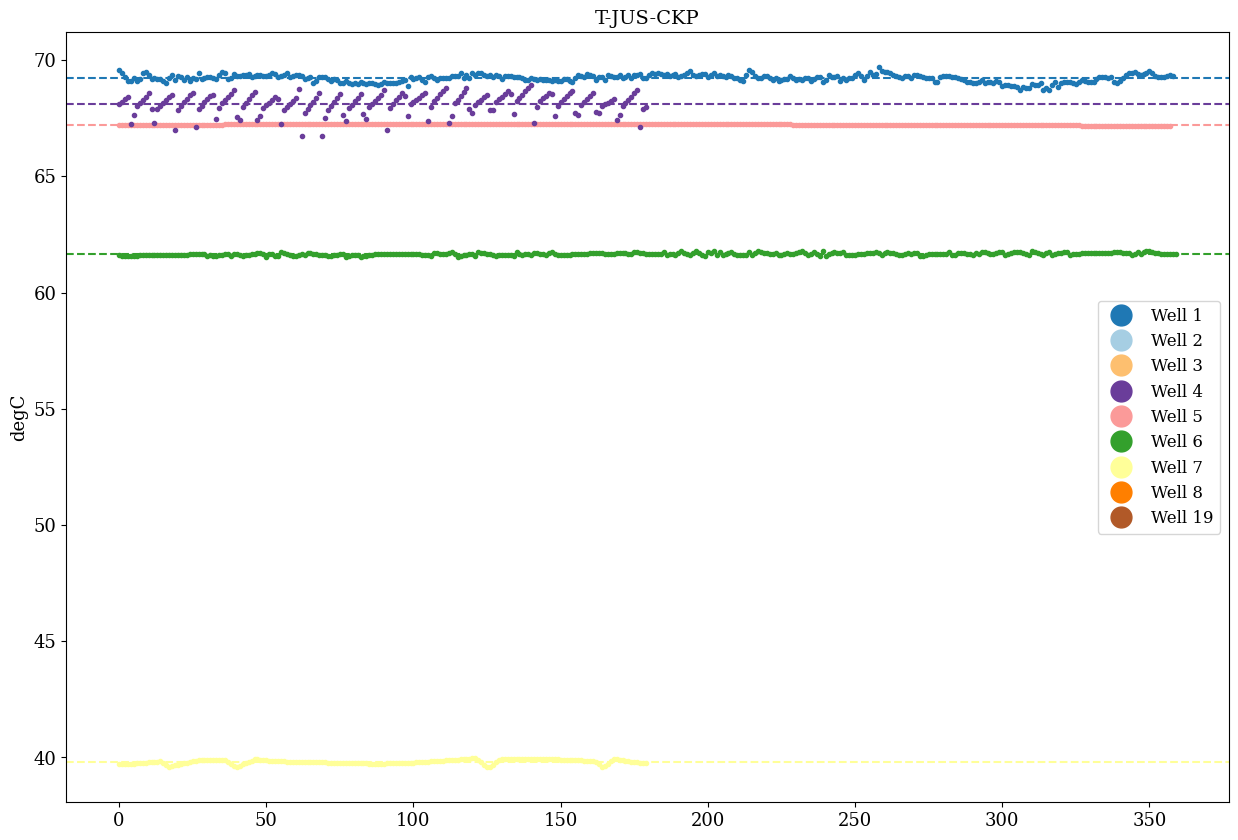

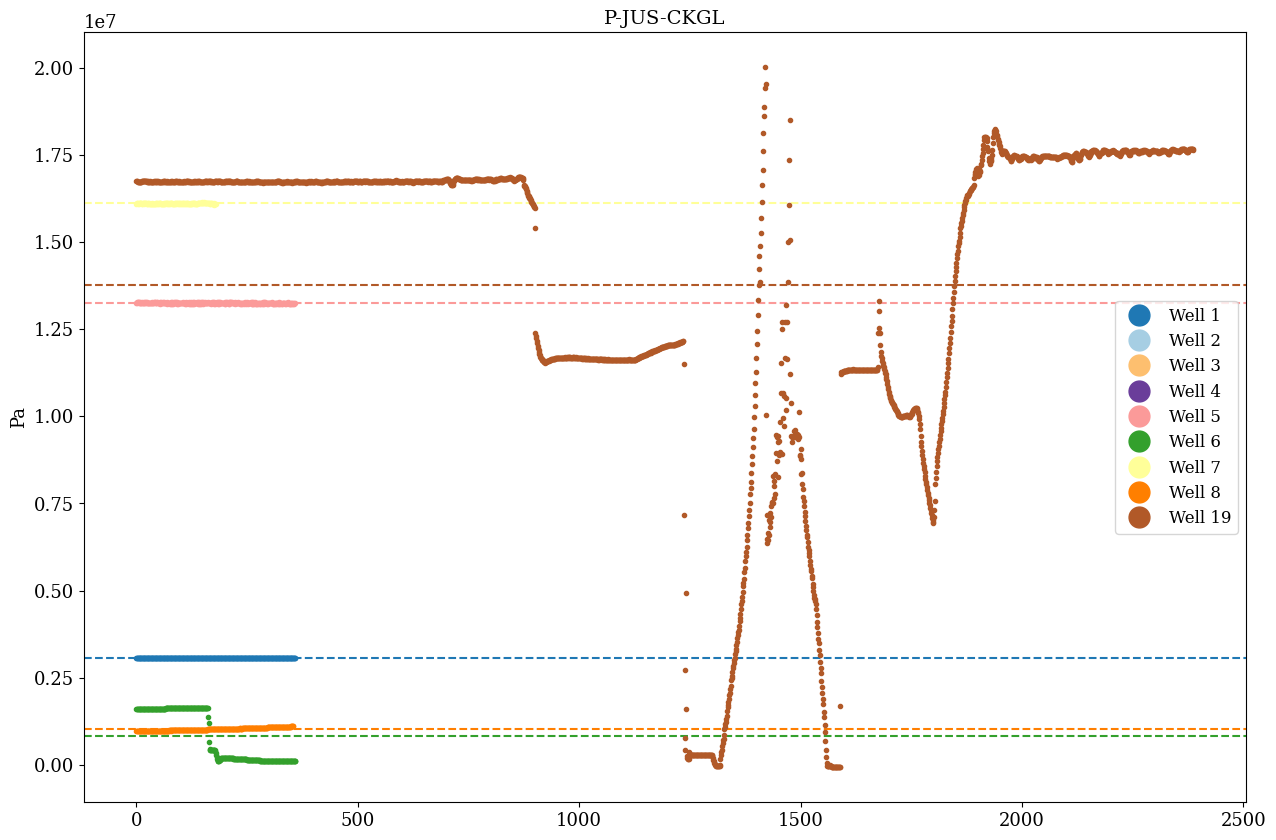

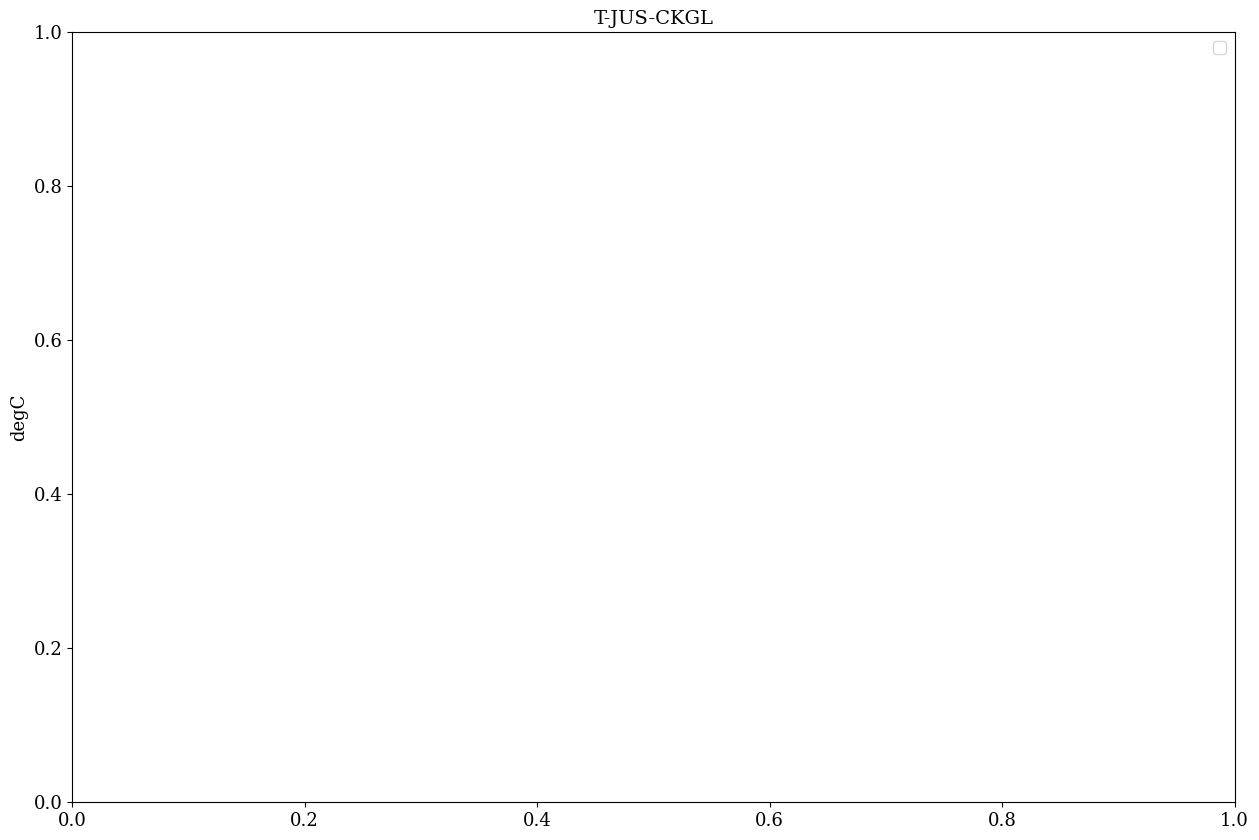

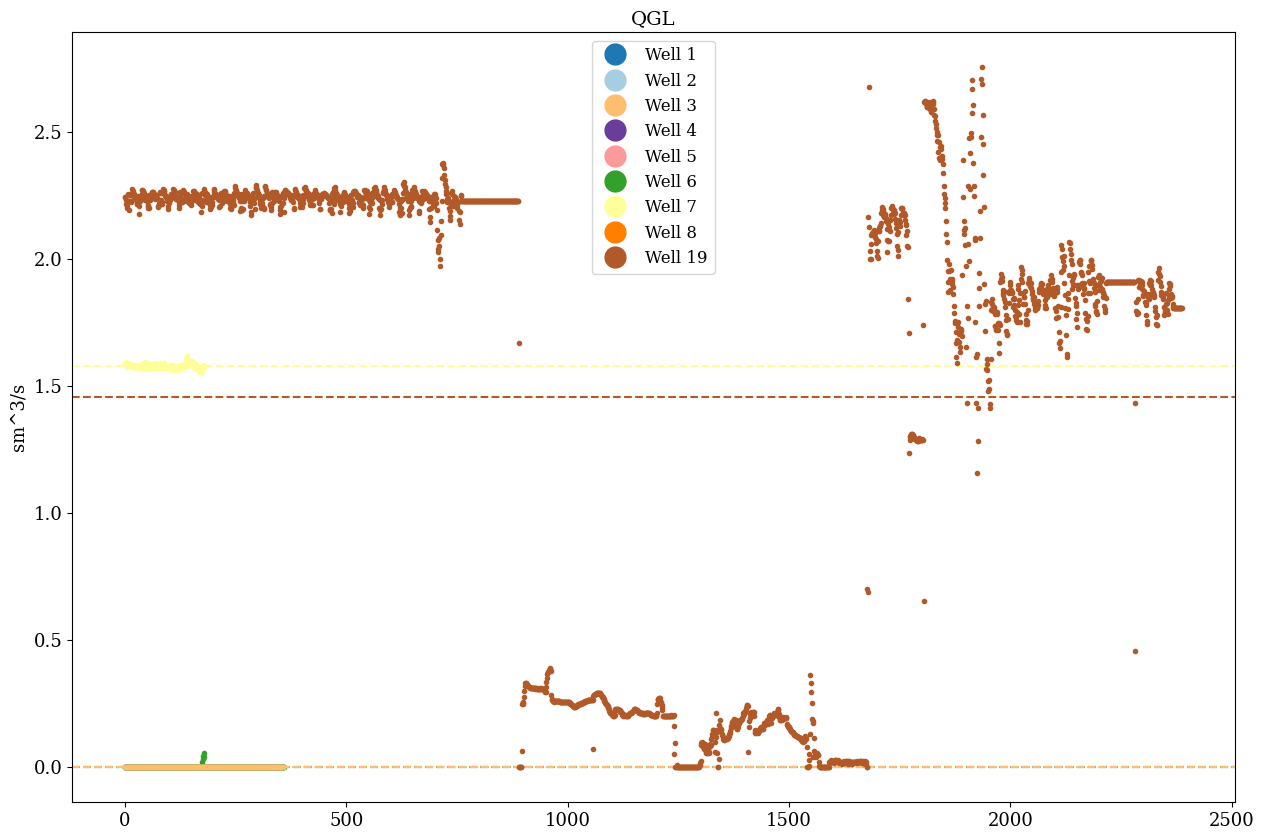

In [ ]:

for tag in tags.keys():
    plot_tag(tag)

### Missing data patterns

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.78 µs


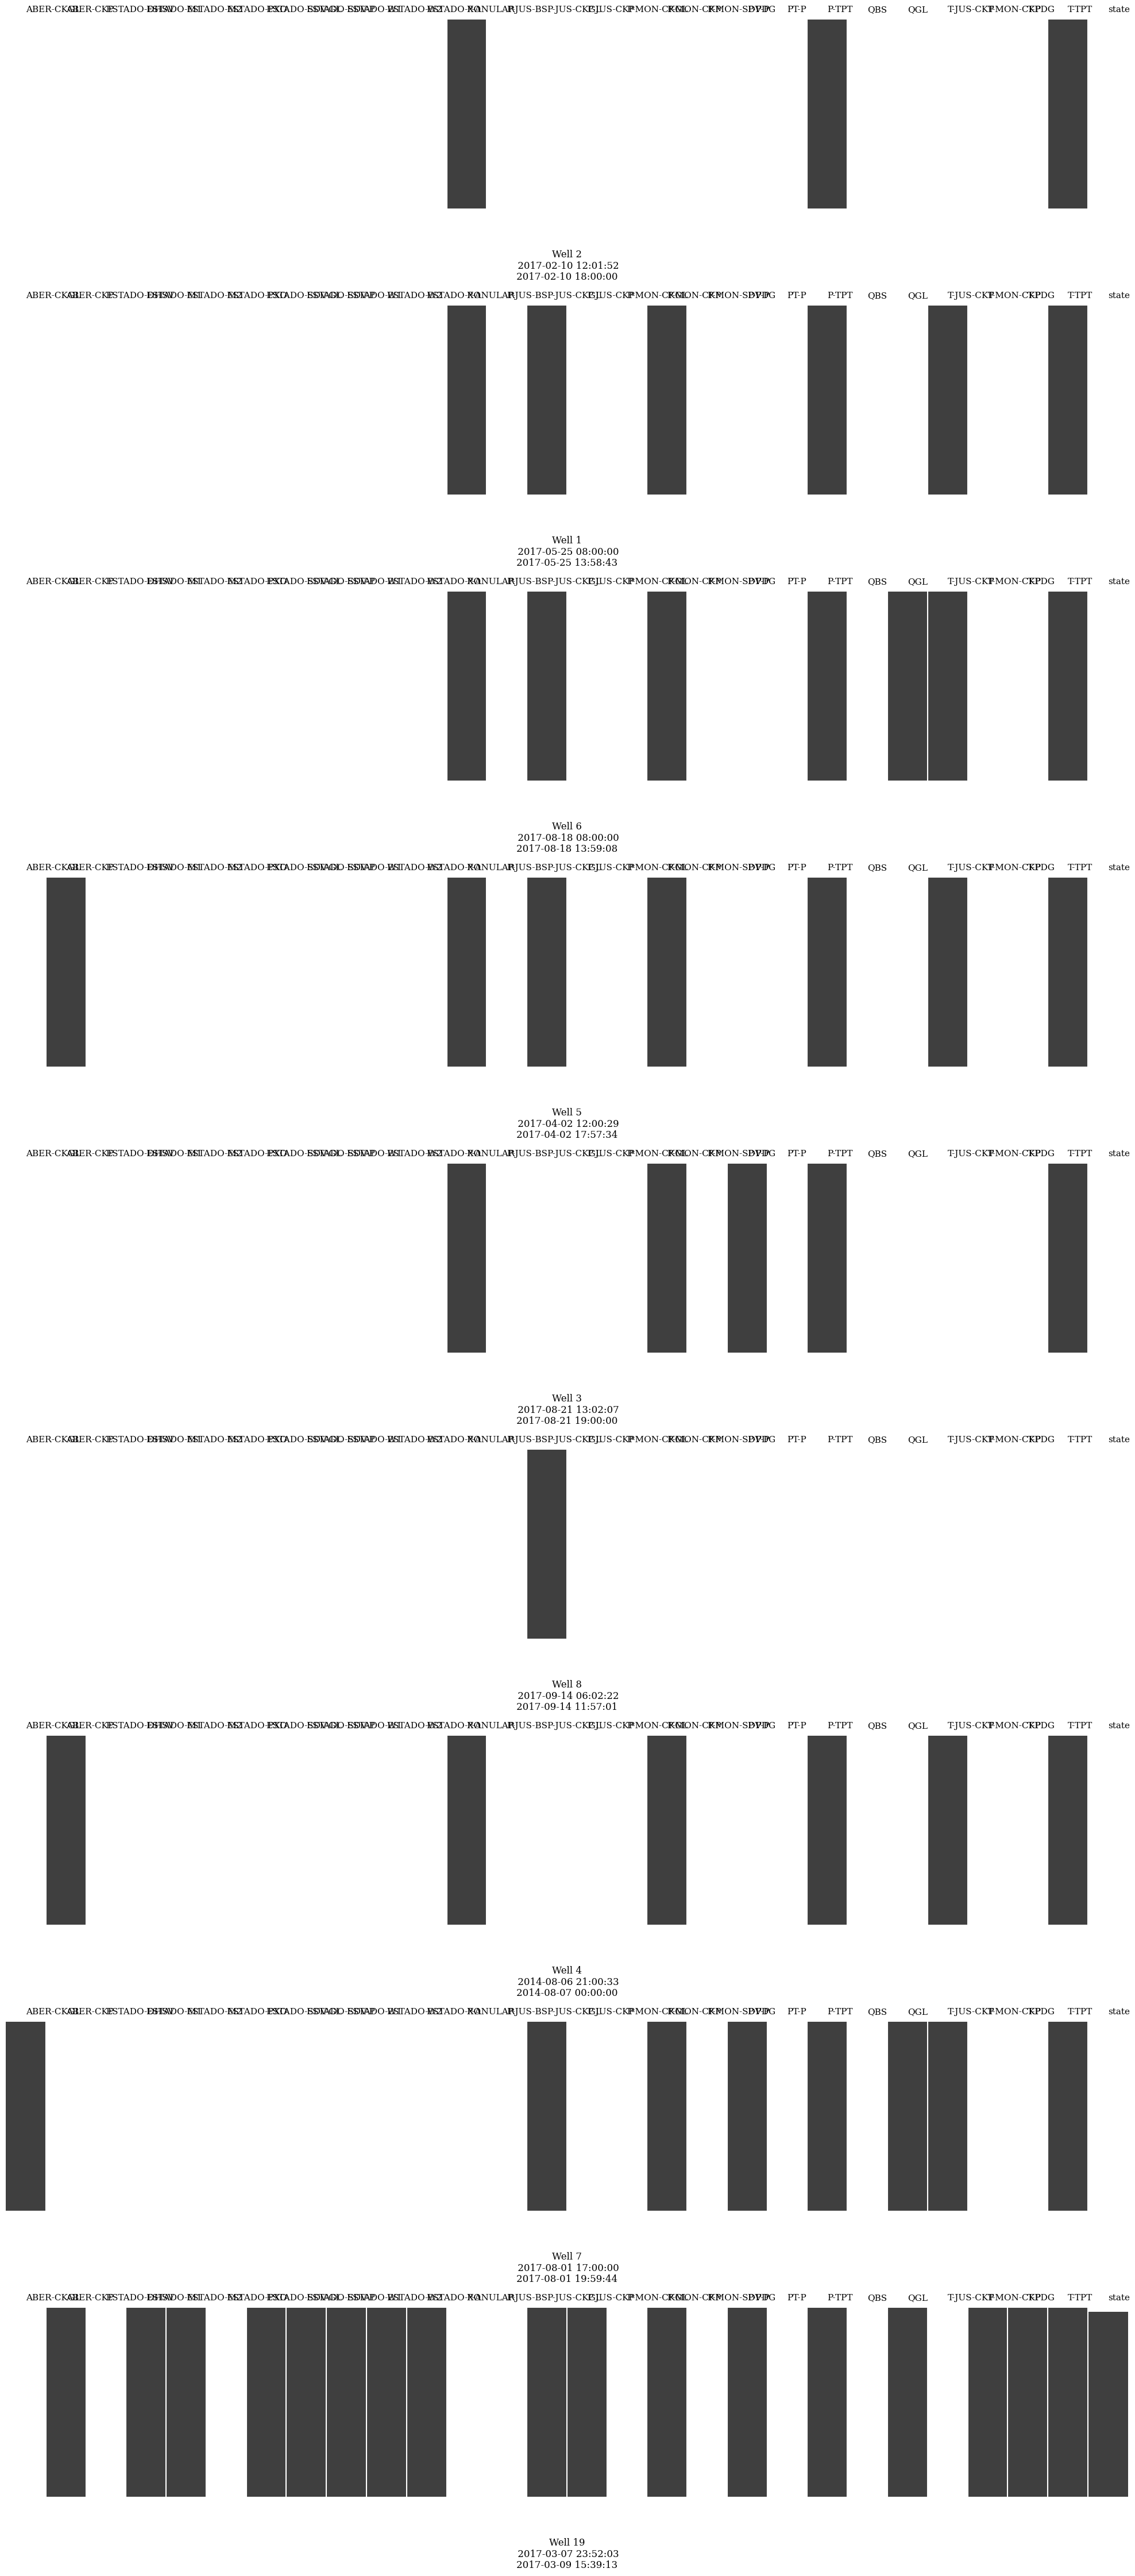

In [ ]:
%time
if len(dfs) > 0:
    fig, ax = plt.subplots(len(dfs), 1, figsize=(20, len(dfs) * 5))
    if len(dfs) == 1:
        ax = [ax]  # Garante que ax seja iterável quando há apenas um subplot

    for i, (well_id, df) in enumerate(dfs.items()):
        df_test = copy.deepcopy(df)
        if 'class' in df_test.columns:
            del df_test['class']
        df_test.columns = df_test.columns
        df_test.loc[:, (df_test.var(ddof=1) < 1e-6)] = np.nan
        missingno.matrix(df_test, sparkline=False, ax=ax[i])
        ax[i].set_yticks([])
        ax[i].xaxis.set_tick_params(labelsize=11, rotation=0)
        ax[i].set_title(f'Well {int(well_id)}\n {df_test.index[0]}\n{df_test.index[-1]}', y=-0.4, fontdict={'fontsize': 12})
        del df_test

    fig.tight_layout()
    plt.show()
else:
    print("Nenhum dado para exibir.")


## Time period analysis

In the following time series charts, instances are separated by blue dashed lines and time periods are separated by thick red lines.

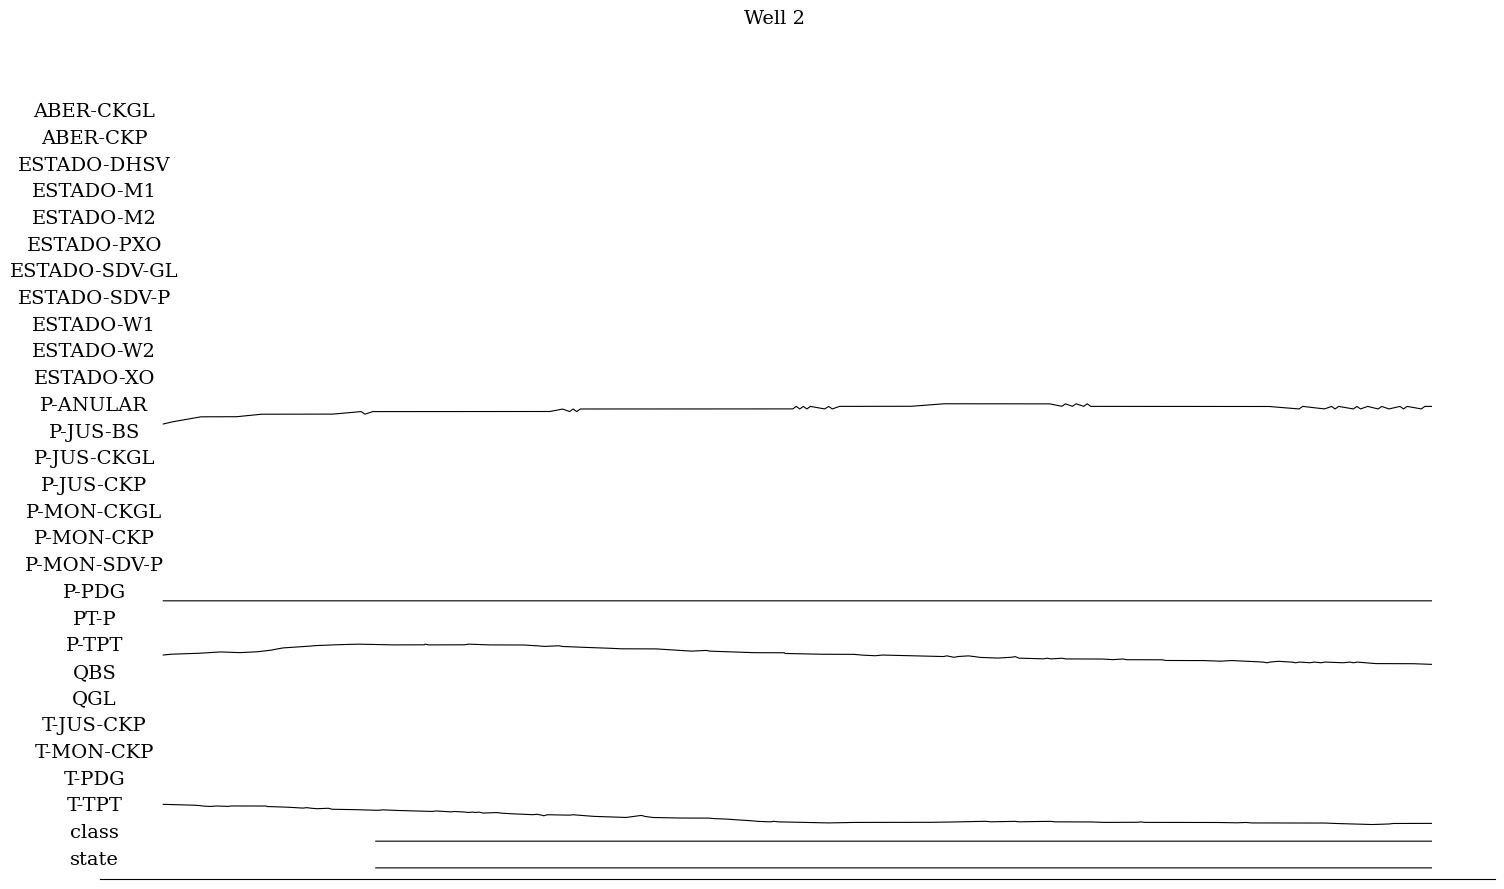

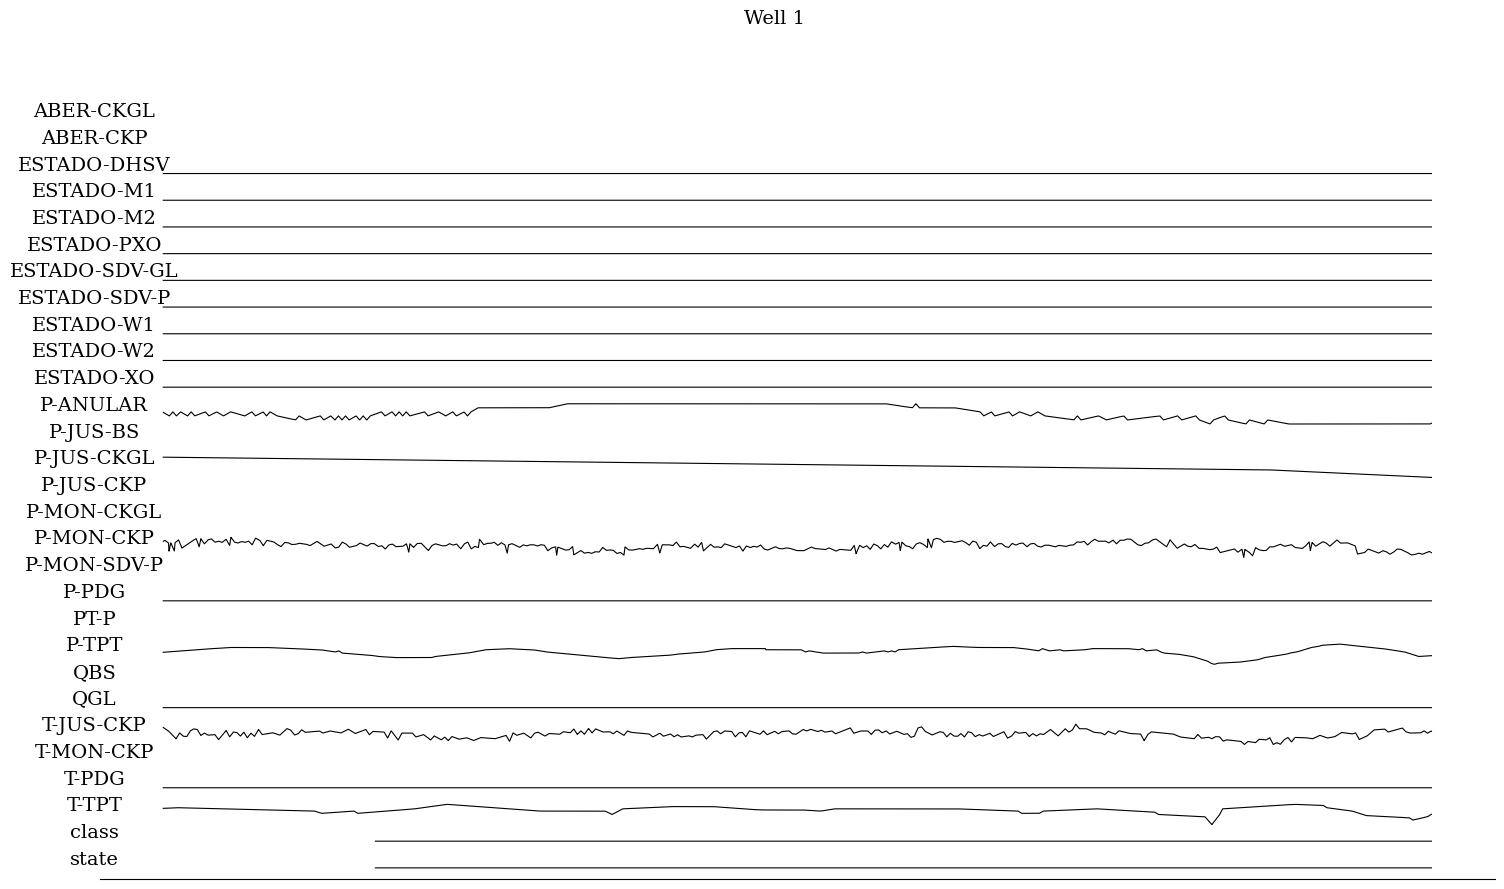

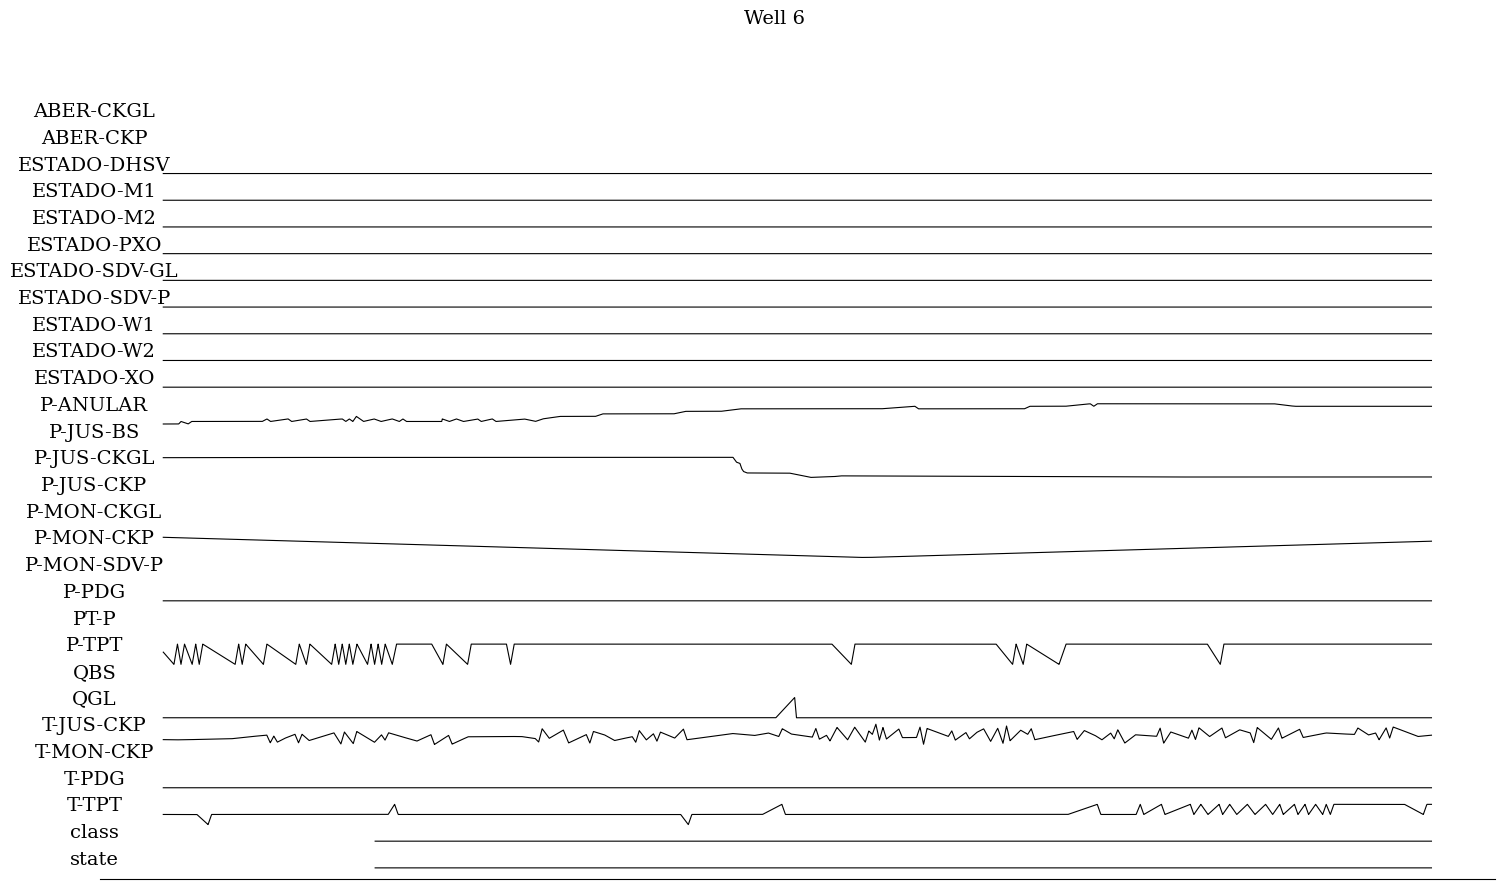

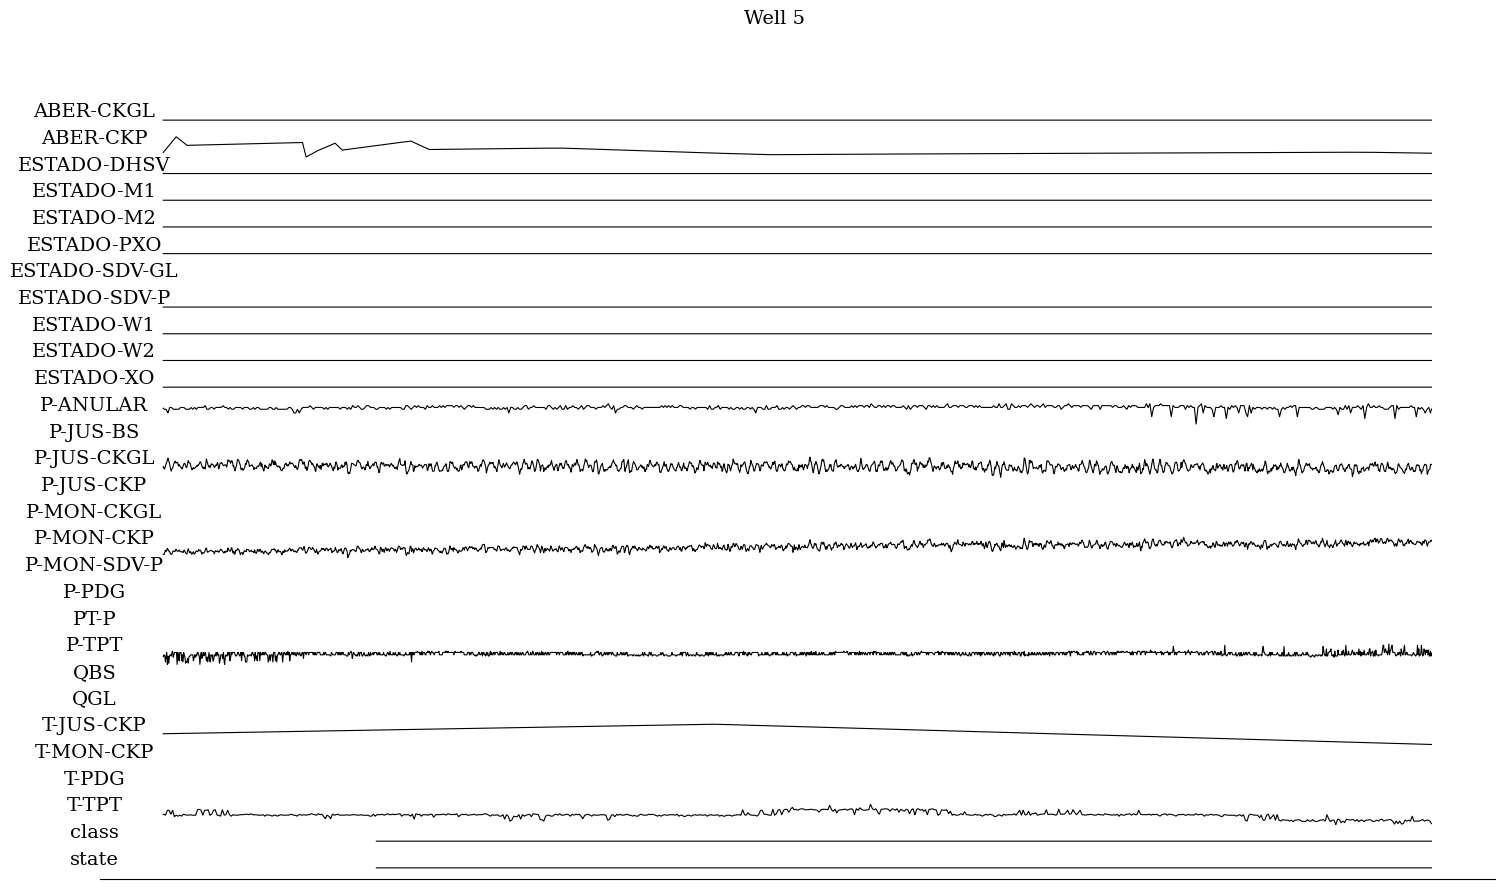

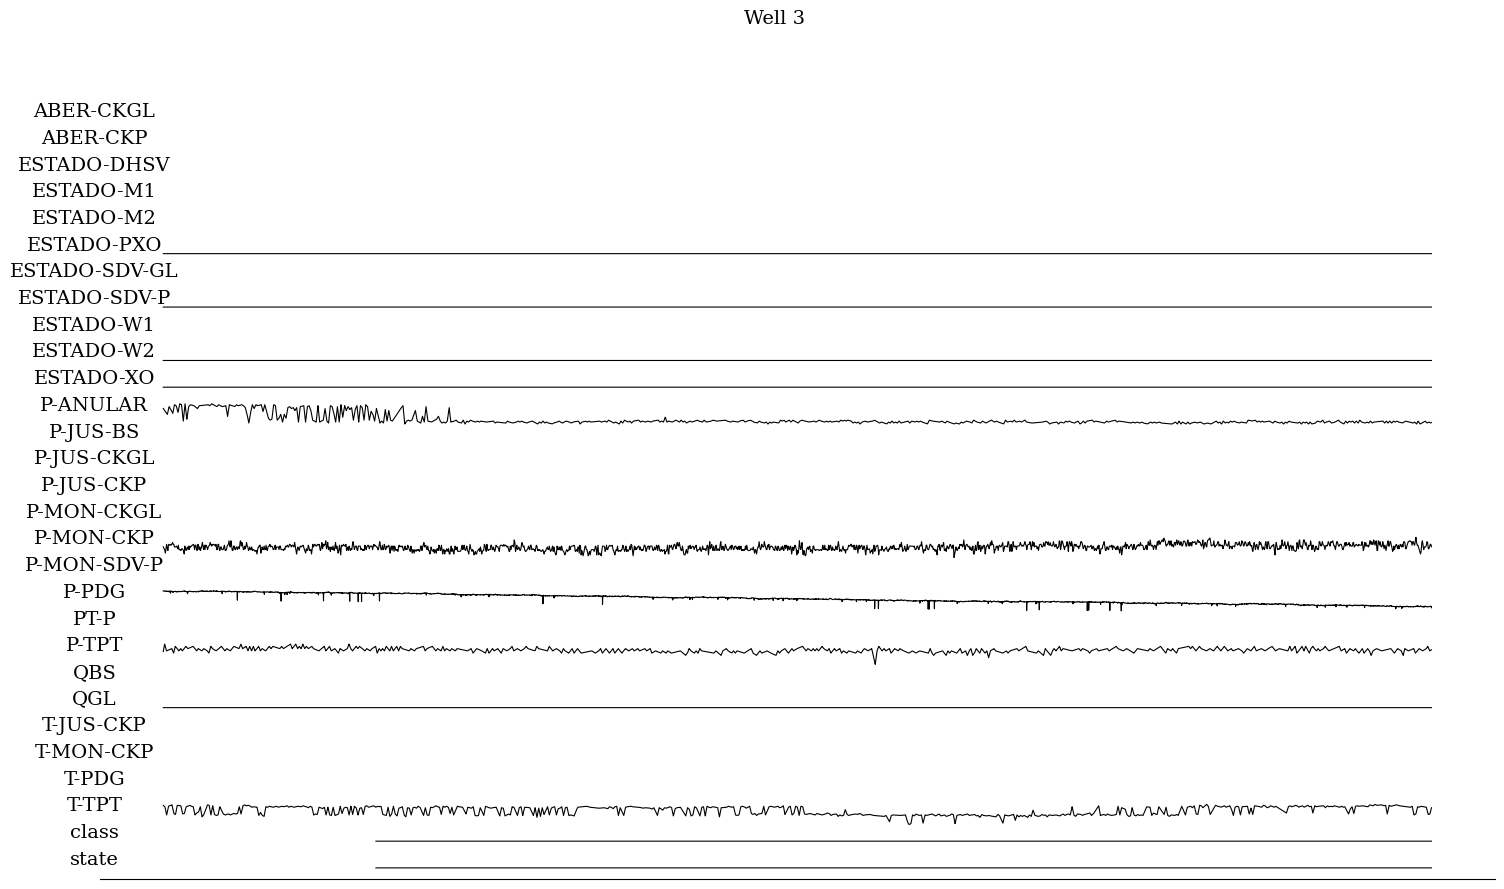

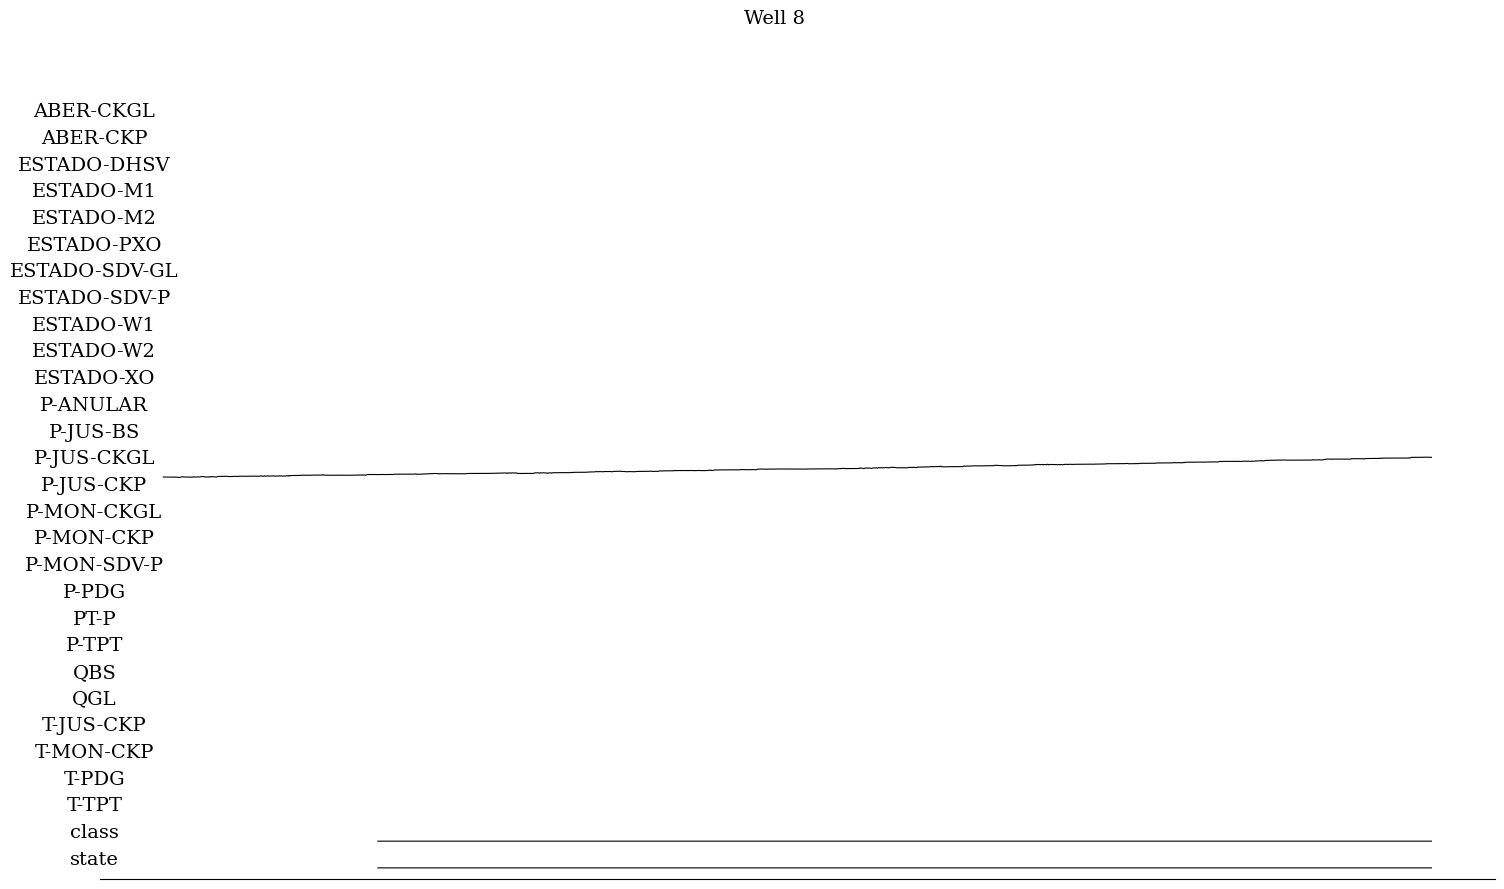

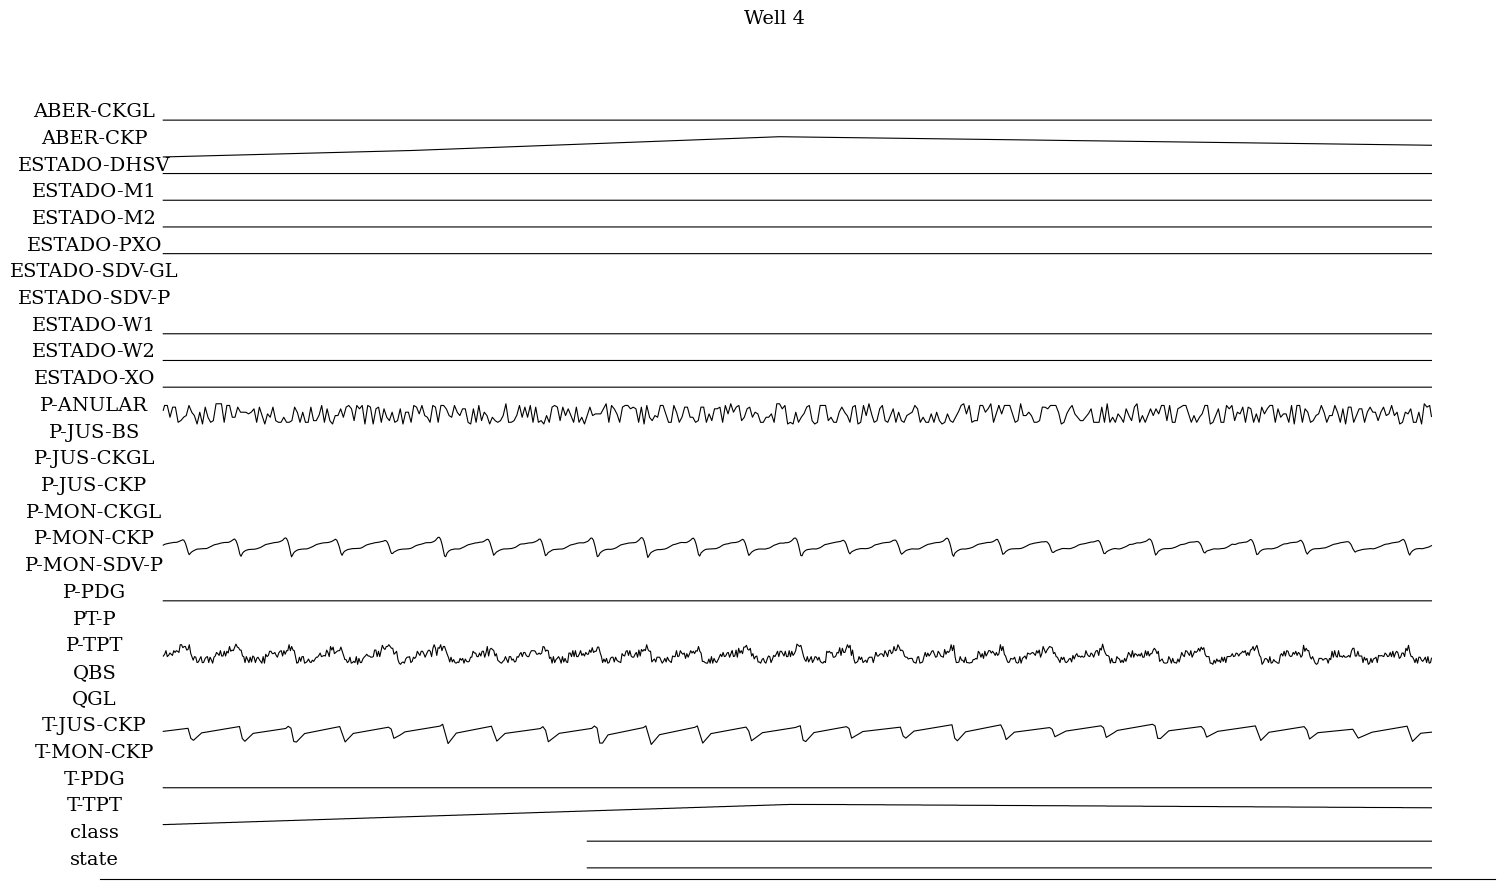

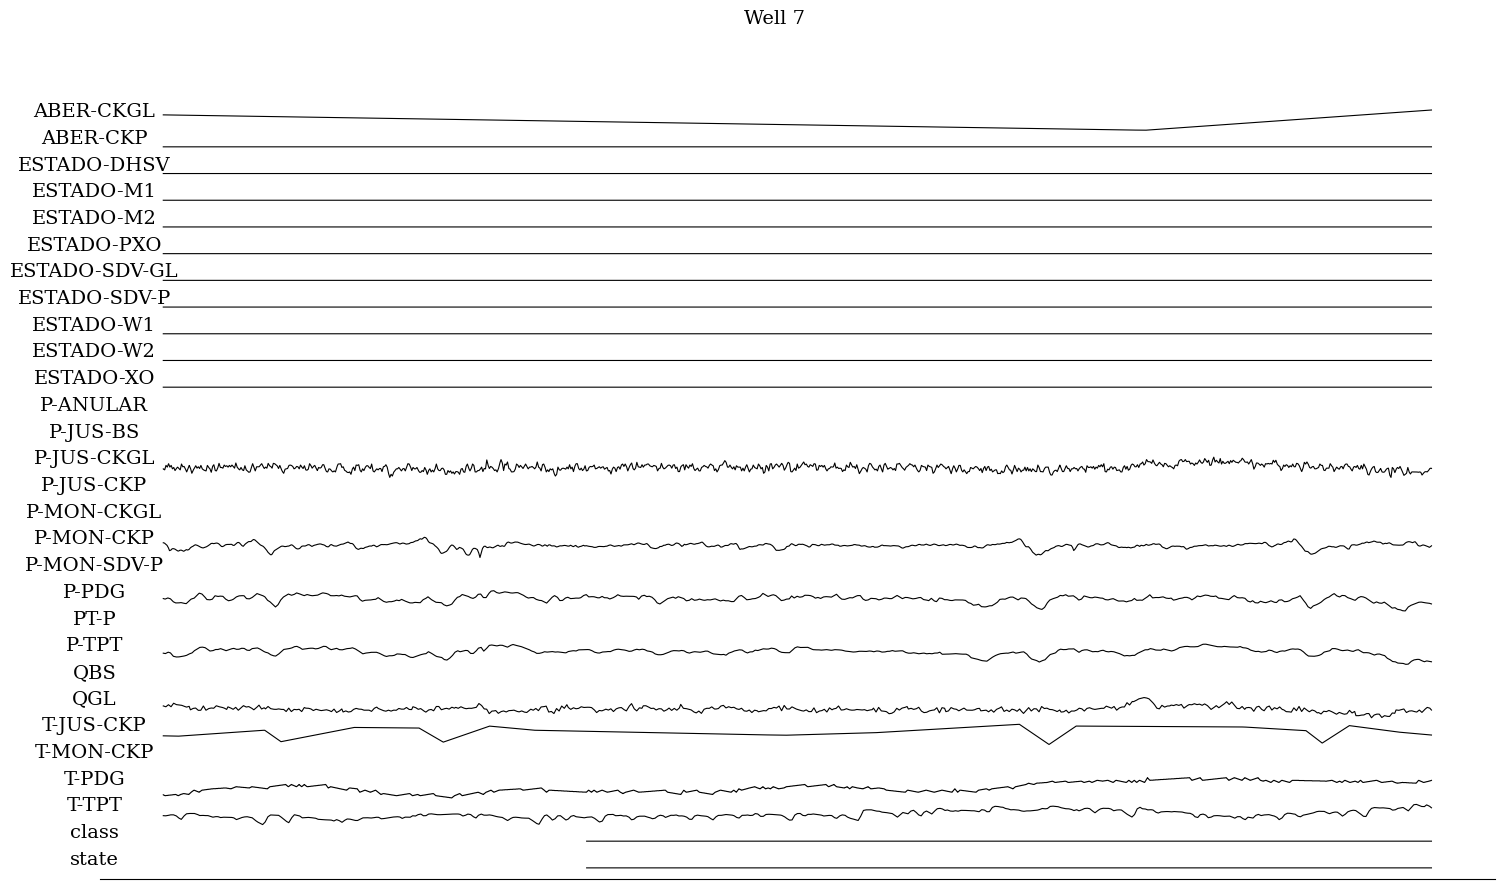

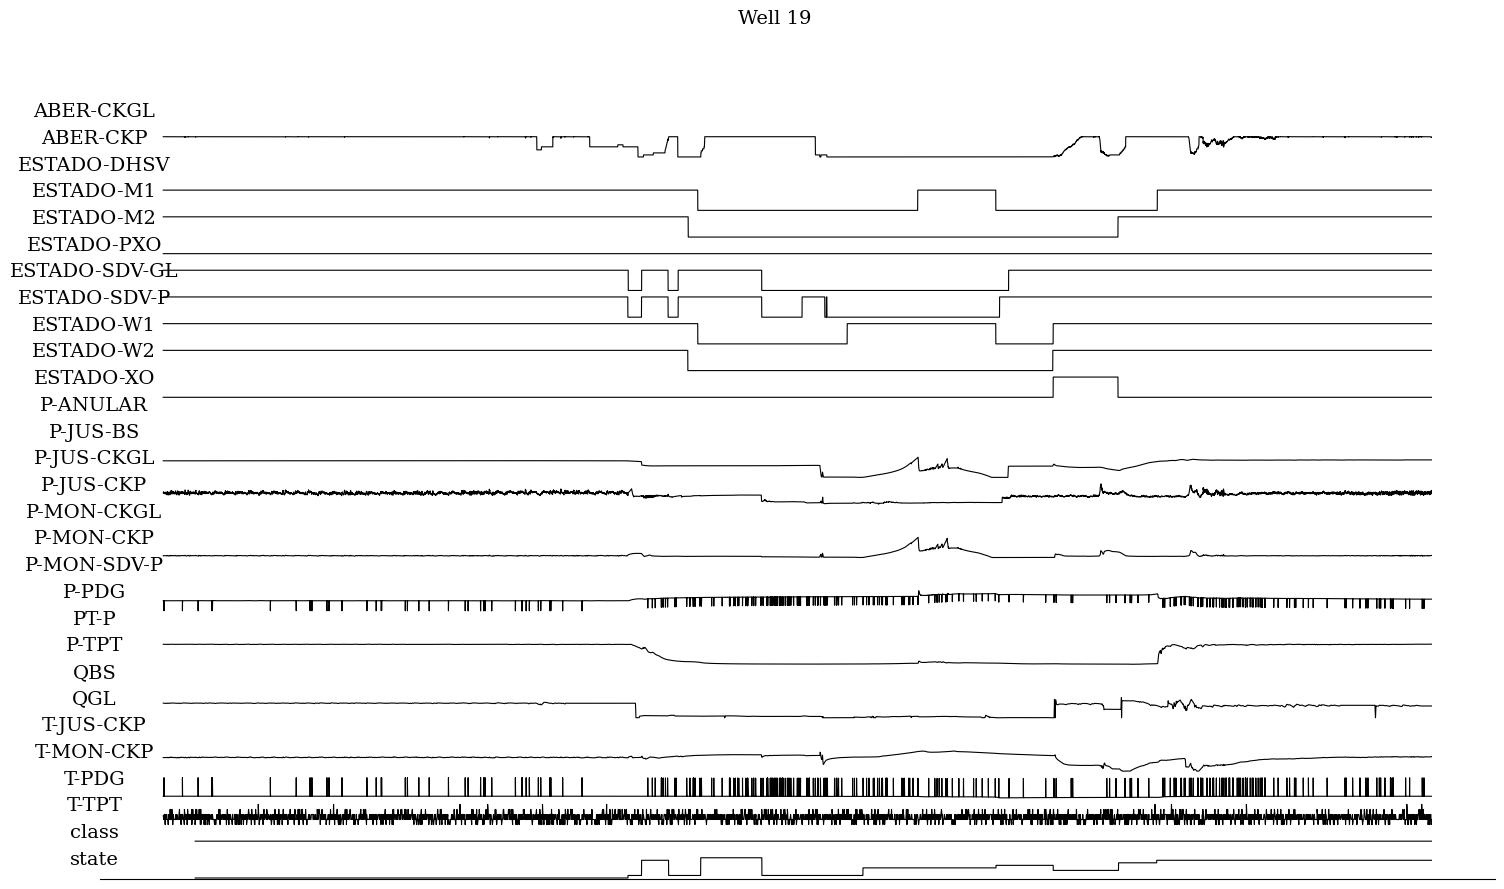

In [ ]:

for well_id, data in dfs.items():
    fig, ax = plt.subplots(data.shape[1], 1, figsize=(18, 10), sharex=True)
    data_well = plot_timeseries_well(ax=ax, data=data)
    plt.suptitle(f'Well {int(well_id)}')
    plt.show()
